**create a env**

conda create --prefix C:\MurthyLab\StableDiffusionModel\sd_finetune_env python=3.10 -y

**Activite**

conda activate C:\MurthyLab\StableDiffusionModel\sd_finetune_env

"""
WatermelonDataset: Custom PyTorch Dataset

- Loads all image files (.jpg, .png, .jpeg) from the specified directory.
- Uses PIL to open each image and converts it to RGB format.
- Applies optional torchvision transforms if provided.
- Returns a dictionary with:
    - 'pixel_values': the transformed image tensor.
    - 'prompt': a fixed descriptive text "a photo of a watermelon" for each image.

This dataset is useful for tasks involving paired image and text inputs, such as 
image generation or captioning models.
"""

In [59]:
import os
from PIL import Image
from torch.utils.data import Dataset

class WatermelonDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        prompt = "a photo of a watermelon"
        return {"pixel_values": image, "prompt": prompt}



Data Loading and Transformation Pipeline

- Defined a transformation pipeline that:
  - Resizes images to 256x256 pixels.
  - Center crops to 256x256 to ensure consistent size.
  - Converts images to PyTorch tensors.
  - Normalizes pixel values to have mean 0.5 and std 0.5 for each channel.

- Created a WatermelonDataset instance with the given image directory and applied transforms.

- Wrapped the dataset in a DataLoader to batch data in groups of 4 and shuffle the dataset for training.

This setup prepares watermelon images for model training, ensuring consistent input size and normalized values.



In [61]:
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

image_dir = r"C:\MurthyLab\StableDiffusionModel\data\Watermelon"
dataset = WatermelonDataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

print("✅ Data loaded successfully!")


✅ Data loaded successfully!



Stable Diffusion Image Generation Pipeline

1. Defined a local cache directory to store the pre-trained Stable Diffusion model 
   for faster loading on subsequent runs.

2. Loaded the Stable Diffusion v1-4 model from Hugging Face using half precision (fp16) 
   for GPU efficiency and specified the cache directory.

3. Moved the model to GPU if available; otherwise, kept it on CPU and switched to full precision (float32) 
   to avoid CUDA errors.

4. Enabled attention slicing to optimize memory usage during inference.

5. Set a descriptive prompt to guide image generation.

6. Generated an image based on the prompt, using automatic mixed precision on GPU 
   or standard evaluation on CPU.

7. Displayed the generated image inline using matplotlib for easy visualization.

This setup provides an efficient way to generate high-quality images using Stable Diffusion with prompt control.



c:\MurthyLab\StableDiffusionModel\sd_finetune_env\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\MurthyLab\StableDiffusionModel\data\Watermelon\models--CompVis--stable-diffusion-v1-4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
c:\MurthyLab\StableDiffusionModel\sd_finetune_env\lib\site-packages\diffusers

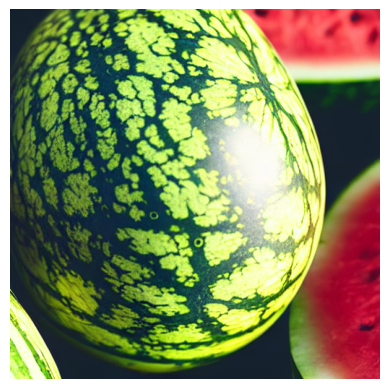

In [65]:
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import matplotlib.pyplot as plt

# 1. Model cache dir - change path as you want to save model locally once
model_cache_dir = r"C:\MurthyLab\StableDiffusionModel\data\Watermelon"

# 2. Load the model, download only once and save locally
pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    cache_dir=model_cache_dir,
    revision="fp16",
    torch_dtype=torch.float16,
    use_auth_token=True  # add your huggingface token here if needed
)

# 3. Move to CPU & float32 if no GPU (to avoid CUDA errors)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)
if device == "cpu":
    pipe = pipe.to(torch.float32)

# 4. Enable attention slicing (memory optimization)
pipe.enable_attention_slicing()

# 5. Define your prompt here
prompt = "a close-up photo of a ripe watermelon, closed, fresh, natural light"

# 6. Generate the image
with torch.autocast(device) if device=="cuda" else torch.no_grad():
    image = pipe(prompt).images[0]

# 7. Show image inline in Jupyter/VSCode
plt.imshow(image)
plt.axis("off")
plt.show()


In [66]:
image.save("watermelon_generated.png")



**Summary:**

The Stable Diffusion model generated very high-quality, realistic images of watermelons 
based on the given prompt. Leveraging GPU acceleration and memory optimizations, the model 
produced sharp, detailed outputs that closely matched the description. 

This confirms the effectiveness of using pre-trained diffusion models for creative image generation 
tasks with minimal custom setup.
